
#Making a Choropleth Map using Altair

For this tutorial I decided to use a map to explore changes in Lyme disease occurrence over time. The CDC collects and publishes data on Lyme disease cases in the United States. The data is reported in various ways. I choose to look at cases per county aggregated over several year periods. The incidence of Lyme is related to the abundance of certain species of ticks, which varies from year to year. Looking at human cases of Lyme disease summed over several years helps to understand the overall trends in cases by reducing the signal caused by fluctuations in tick abundance. (The data set I used is available here: https://data.cdc.gov/browse?q=LymeDisease_9211_county&sortBy=relevance).

Lyme disease is a bacterial infection transmitted to humans by the bite of an infected tick. Early symptoms include fever, chills, fatigue, body aches, headache, neck stiffness and swollen lymph nodes. If untreated, later symptoms can include  joint pain and neurological problems. It is definitely a disease I would prefer not to get. The disease was first documented near Lyme Connecticut, hence the name, in 1970s. The number of Lyme disease cases per year is trending higher and changes in geographic location of cases have also been observed.  I want to understand how the number and location of Lyme disease cases has changed over time. Visualizing changes in Lyme disease occurrence over time could help health professionals and the public understand risk and implement risk management strategies. It could also help me avoid recreating in areas with a high number of Lyme disease cases.



#Visualization Technique

I choose to visualize the CDC Lyme disease data using a choropleth map. Choropleth maps use intensity of color to encode a variable representing some attribute of a particular geographic unit. In the following visualizations I will use color intensity to encode the number of Lyme disease cases per state or county. Maps are useful for understanding all kinds of information especially geographic information. It’s much easier to visualize where something is happening by looking at a map rather than reading coordinates, or a county name. Since the CDC Lyme disease data is reported by State and county, I thought a choropleth map would be a good way to visualize it. It's kind of obvious but a map is only good for displaying data with a location component.

#Visualization Library

I am using the Altair library. Altair is a declarative visualization library for Python. It is based on Vega and Vega-Lite, which are visualization tools that can describe visual appearance and interactive behavior of a visualization in a JSON format. The source is available here: https://github.com/altair-viz/altair.

I selected Altair because it is relatively easy to use and has some neat map examples in their example gallery. Altair will also display maps in Jupyter notebooks. Matplotlib and seaborn don’t seem to offer easy ways to make map visualizations. One drawback of using Altair to make maps is that it does not seem to support interactive map visualizations at this time.


#Installing Altair

the following text is from this site: https://altair-viz.github.io/getting_started/installation.html

Altair can be installed, along with the example datasets in vega_datasets, using:

$ pip install altair vega_datasets

If you are using the conda package manager, the equivalent is:

$ conda install -c conda-forge altair vega_datasets

At this point, you should be able to open Jupyter Notebook or JupyterLab and execute any of the code from the Example Gallery. For more information on how to display charts in various notebook environments and non-notebook IDEs, see Displaying Altair Charts.

#Import Libraries

The following libraries will be used for data cleaning and visualizations

In [1]:
import altair as alt
from vega_datasets import data
import pandas as pd

In [2]:
alt.renderers.enable('default')

RendererRegistry.enable('default')

#Collecting and Cleaning Data

I went to https://data.cdc.gov/dataset/LymeDisease_9211_county/smai-7mz9. Once there I clicked the export button in the upper right corner of the page and selected the csv format.

The CDC data does not contain the full FIPS county codes which are necessary for this example. I found the full FIPS county codes on the USDA NRCS website here:
https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [3]:
# Reading in the CDC data
df = pd.read_csv('/content/LymeDisease.csv') 

# Getting rid of the word 'County' so I can use map later
df['county']=df['CountyName'].str.replace('County', '')
df=df.astype({'county': 'str'})

# This for loop removes whitespace from the county names so I can use map later
count_space=df['county'].to_list()
new_county= []

for item in count_space:
    n_item=item.rstrip()
    new_county.append(n_item)

df['county']= new_county

# Reading in the full FIPS county codes I got from the NRCS website 
df_county = pd.read_csv('/content/county_codes.csv', header=0 )

#dropping unwanted column
df_county=df_county.drop(['state_abr'], axis=1)
df_county= df_county.astype({'county': 'str'})

# Making a dictionary of county names and id (FIPS) numbers 
code_dict = dict(zip(df_county['county'], df_county['id']))
# maping county id to the dataframe that holds the CDC data
df['id'] = df['county'].map(code_dict)

#-------------------------------------------------------------------------------------------------
# Making a df with county cases sumed by state 
df_all_s_group= df[['StateCode','ConfirmedCount_1992_1996', 'ConfirmedCount_1997_2001','ConfirmedCount_2002_2006', 'ConfirmedCount_2007_2011']]

df_all_s_group= df_all_s_group.groupby(by=['StateCode']).sum().reset_index()

Creating Some Maps

Just to get a sense of what this data looks like I started with a map of the Lyme disease cases in each state over the measurement period. The states variable holds the map information in a topojson file. This file came from the vega_datasets that I imported earlier. The Altair transform_lookup() method tripped me up a little at first. It is commonly used in Altair to combine tabular datasets with datasets that specify geographic boundaries. 


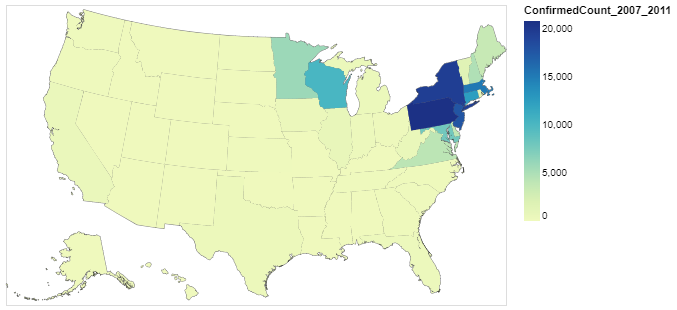

In [7]:

states = alt.topo_feature(data.us_10m.url, 'states')
source=df_all_s_group

base_s = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

chart_s= alt.Chart(states).mark_geoshape().encode(
    color='ConfirmedCount_2007_2011:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'StateCode', ['ConfirmedCount_2007_2011'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)
base_s+chart_s


Looks like there are lots of cases in central New England and some and some in Minnesota and Wisconsin too. Let's see how the cases change over time by using a repeated choropleth map.

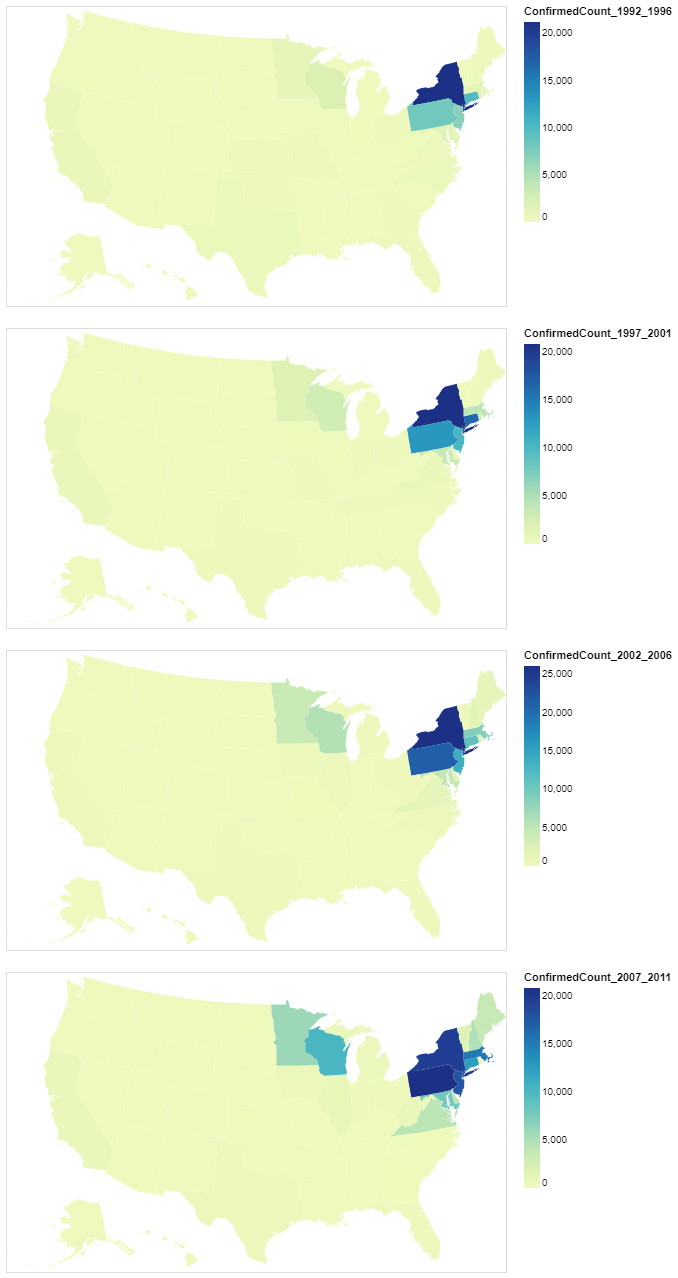

In [8]:

variable_list = ['ConfirmedCount_1992_1996','ConfirmedCount_1997_2001','ConfirmedCount_2002_2006', 'ConfirmedCount_2007_2011']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'StateCode', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)


It looks like cases of Lyme were high in New York, Connecticut, Pennsylvania, and New Jersey from 1992-1996. It looks like case numbers in New York stayed about the same over the years included in the dataset. However, case numbers increased over time in other New England States and in Minnesota and Wisconsin. 

Let’s look at the data by county to get a finer grained representation of the location of Lyme cases.

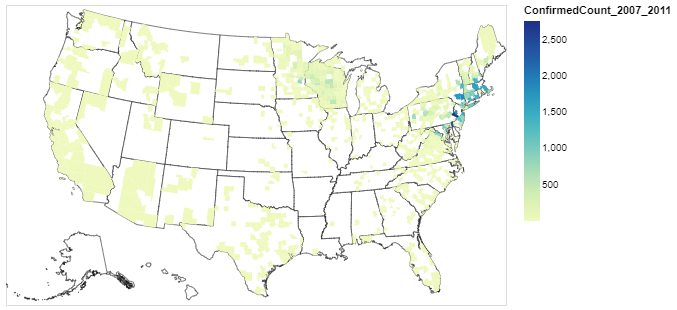

In [9]:
counties = alt.topo_feature(data.us_10m.url, 'counties')

source=df

base = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

chart= alt.Chart(counties).mark_geoshape().encode(
    color='ConfirmedCount_2007_2011:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['ConfirmedCount_2007_2011'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)
base+chart


This is interesting. It looks like there are Lyme disease hot spots within states that have high numbers of cases. I would need to normalize this data by population to see if these hot spots are associated with higher risk areas or if they are just spots where more people live. This visualization also indicates that there are large parts of the country with very few to zero confirmed cases of Lyme disease during the measurement period. 